# Collisional Ionization Equilibrium of H and He

Example of using `pism` to solve for collisional ionization equilibrium (CIE) for a hydrogen-helium mixture and plot the ionization states as a function of temperature.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import numpy as np
from matplotlib import pyplot as plt
import matplotlib
import sympy as sp

# Simple processes
A simple process is defined by a single reaction, with a specified rate.

Let's inspect the structure of a single process, the gas-phase recombination of H+: `H+ + e- -> H + hν` 

In [2]:
from pism.processes import CollisionalIonization, GasPhaseRecombination

process = GasPhaseRecombination("H+")
print(f"Name: {process.name}")
print(f"Heating rate coefficient: {process.heat_rate_coefficient}")
print(f"Heating rate per cm^-3: {process.heat}"),
print(f"Rate coefficient: {process.rate_coefficient}")
print(f"Recombination rate per cm^-3: {process.rate}")
print(f"RHS of e- number density equation: {process.network["e-"]}")

Name: Gas-phase recombination of H+
Heating rate coefficient: -3.46353238381543e-26*T**0.3/(6.30957344480194e-5*T**0.7 + 1)
Heating rate per cm^-3: -3.46353238381543e-26*T**0.3*n_H+*n_e-/(6.30957344480194e-5*T**0.7 + 1)
Rate coefficient: 3.34410023264938e-10/(T**0.7*(6.30957344480194e-5*T**0.7 + 1))
Recombination rate per cm^-3: 3.34410023264938e-10*n_H+*n_e-/(T**0.7*(6.30957344480194e-5*T**0.7 + 1))
RHS of e- number density equation: -3.34410023264938e-10*n_H+*n_e-/(T**0.7*(6.30957344480194e-5*T**0.7 + 1))


Note that all symbolic representations assume CGS units as is standard in ISM physics.

## Composing processes
Now let's define our full network as a sum of simple processes

In [3]:
processes = [CollisionalIonization(s) for s in ("H", "He", "He+")] + [GasPhaseRecombination(i) for i in ("H+", "He+", "He++")]
#processes = [CollisionalIonization(s) for s in ("H",)] + [GasPhaseRecombination(i) for i in ("H+",)]

system = sum(processes)

Summed processes keep track of all subprocesses, e.g. the total net heating rate is:

In [4]:
system.heat

-1.5e-10*n_He+*n_e-/T**0.3647 - 3.46353238381543e-26*T**0.3*n_H+*n_e-/(6.30957344480194e-5*T**0.7 + 1) - 1.38541295352617e-25*T**0.3*n_He++*n_e-/(6.30957344480194e-5*T**0.7 + 1) + 1.2746917300104e-21*sqrt(T)*n_H*n_e-*exp(-157809.1/T)/(sqrt(10)*sqrt(T)/1000 + 1) + 9.37661057635428e-22*sqrt(T)*n_He*n_e-*exp(-285335.4/T)/(sqrt(10)*sqrt(T)/1000 + 1) + 4.9524176975855e-22*sqrt(T)*n_He+*n_e-*exp(-631515/T)/(sqrt(10)*sqrt(T)/1000 + 1)

Summing processes also sums all chemical and gas/dust cooling/heating rates. 

In [5]:
system.print_network_equations()

dn_H+/dt = n_e-*(5.85e-8*T**1.2*n_H*(6.30957344480194e-5*T**0.7 + 1) - 3.34410023264938e-10*n_H+*(sqrt(10)*sqrt(T) + 1000)*exp(157809.1/T))*exp(-157809.1/T)/(T**0.7*(6.30957344480194e-5*T**0.7 + 1)*(sqrt(10)*sqrt(T) + 1000))
dn_He++/dt = n_e-*(5.68e-9*T**1.2*n_He+*(6.30957344480194e-5*T**0.7 + 1) - 1.33764009305975e-9*n_He++*(sqrt(10)*sqrt(T) + 1000)*exp(631515/T))*exp(-631515/T)/(T**0.7*(6.30957344480194e-5*T**0.7 + 1)*(sqrt(10)*sqrt(T) + 1000))
dn_H/dt = n_e-*(-5.85e-8*T**1.2*n_H*(6.30957344480194e-5*T**0.7 + 1) + 3.34410023264938e-10*n_H+*(sqrt(10)*sqrt(T) + 1000)*exp(157809.1/T))*exp(-157809.1/T)/(T**0.7*(6.30957344480194e-5*T**0.7 + 1)*(sqrt(10)*sqrt(T) + 1000))
dn_He+/dt = n_e-*(-T**0.7*n_He+*(6.30957344480194e-5*T**0.7 + 1)*(sqrt(10)*sqrt(T) + 1000)*(T**0.6353*(0.0019*exp(94000.0/T) + 0.00057) + 1.5e-10*T**1.5*exp(564000.0/T))*exp(916850.4/T) + 1.33764009305975e-9*T**2.1353*n_He++*(sqrt(10)*sqrt(T) + 1000)*exp(1480850.4/T) + 2.38e-8*T**3.3353*n_He*(6.30957344480194e-5*T**0.7 + 1

## Solving ionization equilibrium

Today we would like to solve for ionization equilibrium given a temperature `T`. That means finding the chemical abundances that set this thing to 0:

In [6]:
system.network["e-"]

-3.34410023264938e-10*n_H+*n_e-/(T**0.7*(6.30957344480194e-5*T**0.7 + 1)) - 1.33764009305975e-9*n_He++*n_e-/(T**0.7*(6.30957344480194e-5*T**0.7 + 1)) + 5.85e-11*sqrt(T)*n_H*n_e-*exp(-157809.1/T)/(sqrt(10)*sqrt(T)/1000 + 1) + 2.38e-11*sqrt(T)*n_He*n_e-*exp(-285335.4/T)/(sqrt(10)*sqrt(T)/1000 + 1) + 5.68e-12*sqrt(T)*n_He+*n_e-*exp(-631515/T)/(sqrt(10)*sqrt(T)/1000 + 1) - n_He+*n_e-*(0.0019*(1 + 0.3*exp(-94000.0/T))*exp(-470000.0/T)/T**1.5 + 1.5e-10/T**0.6353)

The full network above had 6 equations, but we may introduce two known quantities: the total H number density and the helium mass fraction Y.

`n_Htot = n_H + n_H+`

`n_He + n_He+ + n_He++ = Y/(4-Y) n_Htot`

We may also invoke conservation of electrons:

`n_e- = n_H+ + n_He+ + 2 n_He++`

This allows us to eliminate 3 variables from the system.

In [ ]:
Y = sp.symbols("Y")
nHtot = sp.symbols("n_Htot")

substitutions = {
                "n_e-": sp.symbols("n_H+") + sp.symbols("n_He+")  + sp.symbols("n_He++"),
                "n_H+": nHtot - sp.symbols("n_H"),
                 "n_He++": Y/(4-4*Y) * nHtot - sp.symbols("n_He") - sp.symbols("n_He+"),                  
}

for species in system.network:
    for s in substitutions:
        system.network[species] = system.network[species].subs(s, substitutions[s])

system.network

defaultdict(int,
            {'H+': -3.34410023264938e-10*(-n_H + n_Htot)*(Y*n_Htot/(4 - Y) - n_H - n_He + n_Htot)/(T**0.7*(6.30957344480194e-5*T**0.7 + 1)) + 5.85e-11*sqrt(T)*n_H*(Y*n_Htot/(4 - Y) - n_H - n_He + n_Htot)*exp(-157809.1/T)/(sqrt(10)*sqrt(T)/1000 + 1),
             'He++': -1.33764009305975e-9*(Y*n_Htot/(4 - Y) - n_He - n_He+)*(Y*n_Htot/(4 - Y) - n_H - n_He + n_Htot)/(T**0.7*(6.30957344480194e-5*T**0.7 + 1)) + 5.68e-12*sqrt(T)*n_He+*(Y*n_Htot/(4 - Y) - n_H - n_He + n_Htot)*exp(-631515/T)/(sqrt(10)*sqrt(T)/1000 + 1),
             'H': 3.34410023264938e-10*(-n_H + n_Htot)*(Y*n_Htot/(4 - Y) - n_H - n_He + n_Htot)/(T**0.7*(6.30957344480194e-5*T**0.7 + 1)) - 5.85e-11*sqrt(T)*n_H*(Y*n_Htot/(4 - Y) - n_H - n_He + n_Htot)*exp(-157809.1/T)/(sqrt(10)*sqrt(T)/1000 + 1),
             'He+': 1.33764009305975e-9*(Y*n_Htot/(4 - Y) - n_He - n_He+)*(Y*n_Htot/(4 - Y) - n_H - n_He + n_Htot)/(T**0.7*(6.30957344480194e-5*T**0.7 + 1)) + 2.38e-11*sqrt(T)*n_He*(Y*n_Htot/(4 - Y) - n_H - n_He + n_

### Symbolic Jacobian
For our remaining unknowns we can define a Jacbon w.r.t. those quantities:

In [8]:
unknowns = sp.symbols("n_H n_He n_He+")
#unknowns = sp.symbols("n_H n_e-")
knowns = sp.symbols("T n_Htot Y")

jac = []
reduced_network = []
for species, rhs in system.network.items(): 
    if f"n_{species}" in substitutions: continue
    reduced_network.append(rhs)
    jac.append([sp.diff(rhs, u) for u in unknowns])

sp.Matrix(jac)

Matrix([
[-3.34410023264938e-10*(-n_H + n_Htot)/(T**0.7*(6.30957344480194e-5*T**0.7 + 1)) - 3.34410023264938e-10*(Y*n_Htot/(4 - Y) - n_H - n_He + n_Htot)/(T**0.7*(6.30957344480194e-5*T**0.7 + 1)) + 5.85e-11*sqrt(T)*n_H*exp(-157809.1/T)/(sqrt(10)*sqrt(T)/1000 + 1) - 5.85e-11*sqrt(T)*(Y*n_Htot/(4 - Y) - n_H - n_He + n_Htot)*exp(-157809.1/T)/(sqrt(10)*sqrt(T)/1000 + 1),                                                                                                                                                                                                                                                                                                                                                                                                -3.34410023264938e-10*(-n_H + n_Htot)/(T**0.7*(6.30957344480194e-5*T**0.7 + 1)) + 5.85e-11*sqrt(T)*n_H*exp(-157809.1/T)/(sqrt(10)*sqrt(T)/1000 + 1),                                                                                                   

## Numerical solution

To solve the system numerically we may use Newton iterations:

$$ \mathbf{X}_{n+1} = \mathbf{X}_{\rm n} - \mathbf{J}^{-1}\left(\mathbf{X}_{\rm n}\right) \mathbf{f(\mathbf{X}_{\rm n})}$$

where $\mathbf{X}$ is the vector of unknowns, $\mathbf{f}(\mathbf{X})$ is the vector of RHS in the chemical rates we wish to solve = 0, and $J$ is the Jacobian of $f(X)$.

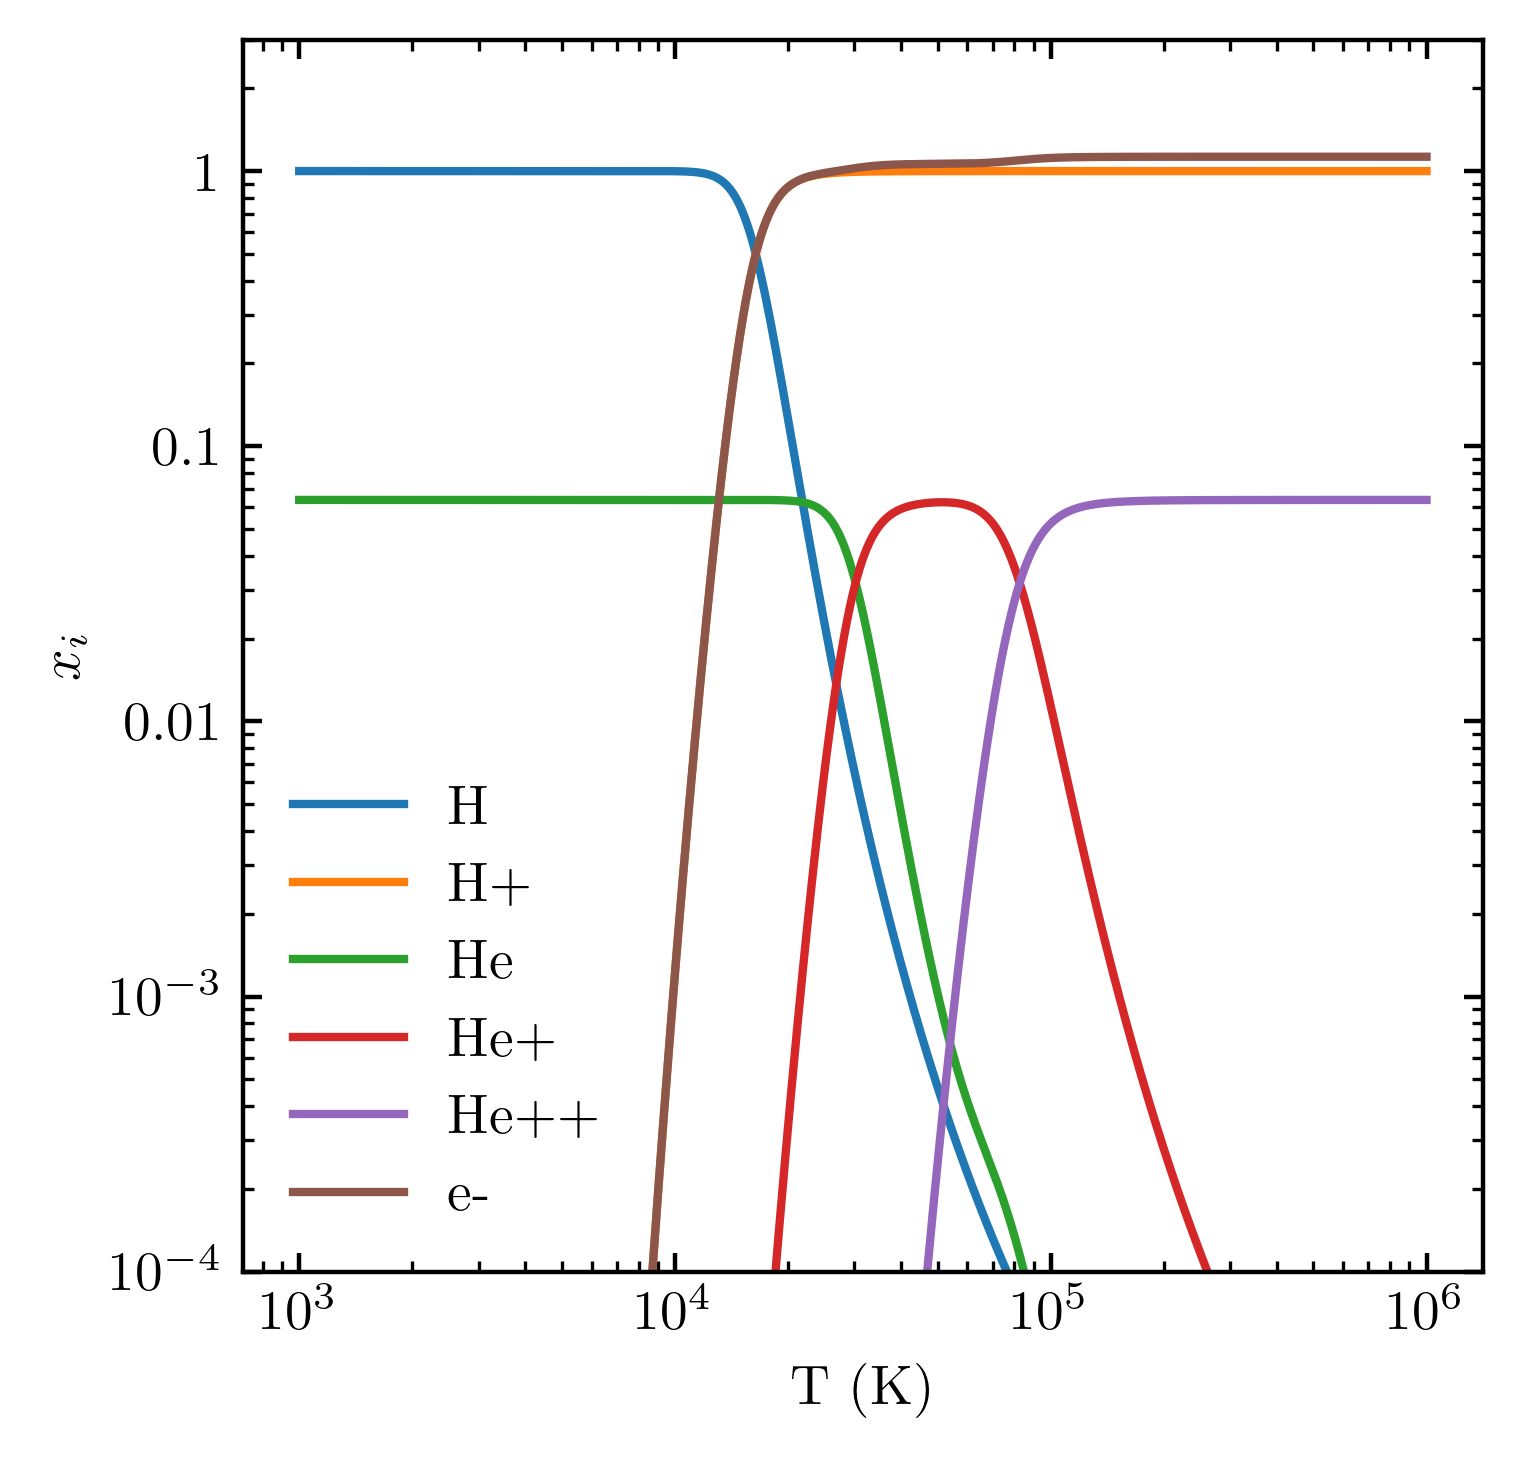

In [9]:
from scipy.optimize import fsolve

 #1e-6,1e-6,0.5) # n_H n_He n_He+ n_e- initial guess

func = sp.lambdify(unknowns+knowns, reduced_network) # what is going on in the backend here?
jacfunc =  sp.lambdify(unknowns + knowns, jac)


def solve_abundances(Tval, x0=None):
    knownvals = (Tval, 1, 0.24)

    def f_numerical(X):
        arg = tuple(X) + knownvals
        return func(*arg)

    def jac_numerical(X):
        arg = tuple(X) + knownvals
        return jacfunc(*arg)

    if x0 is None:
        x0 = np.array([0.5,1e-5, 1e-5])

    X = x0
    X_iter = []
    dx = 1e100 * x0
    tol = 1e-1
    n_iter = 0
    while(np.any(np.abs(dx/X) > tol)):
        X_iter.append(np.copy(X))
        J = jac_numerical(X)
        f = f_numerical(X)
        dx = -np.linalg.solve(J, f) # don't actually have to invert!
        X += dx
        n_iter += 1

    return X

Tgrid = np.logspace(3,6,10**4)
x0 = solve_abundances(Tgrid[0])

sol = []
for T in Tgrid:
    x0 = solve_abundances(T,x0=x0)
    sol.append(np.copy(x0))

sol = np.array(sol)


# need to abstract this process of substituting the conservation equations...
Y = 0.24
nHtot = 1
nHepp = Y/(4-Y)*nHtot - sol[:,1] - sol[:,2] 
sol = np.c_[sol, nHepp]
nHp = nHtot - sol[:,0]
ne = 2*nHepp + nHp + sol[:,2]
sol = np.c_[sol[:,0],nHp,sol[:,1],sol[:,2], nHepp, ne]

#plt.title(r"$n_{\rm H,tot}=1\,\rm cm^{-3}$")
plt.loglog(Tgrid, sol, label=("H", "H+", "He", "He+", "He++", "e-"))#,label=unknowns)
plt.ylim(1e-4,3)
plt.ylabel(r"$x_i$")
#plt.ylabel(r"$n_i\,\left(\rm cm^{-3}\right)$")
plt.xlabel(r"T (K)")
plt.legend()

In [11]:
ne.max()

np.float64(1.127654981341093)

In [14]:
4 * (nHepp+sol[:,2]+sol[:,3]) / (4 * (nHepp+sol[:,2]+sol[:,3]) + 1)

array([0.20338983, 0.20338983, 0.20338983, ..., 0.20338983, 0.20338983,
       0.20338983])